In [1]:
from cmath import isnan

import pyproj.datadir

pyproj.datadir.set_data_dir('/opt/homebrew/Cellar/proj/9.5.1/share/proj')

/Users/manuel/Documents/Semester 4/Master_Thesis/Thesis_Repo/venv/lib/python3.11/site-packages/pyproj/__init__.py:96: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
from shapely.geometry import Point, LineString, Polygon
import shapely
import momepy as mp
import esda
import seaborn as sns
sns.set_theme()

/Users/manuel/Documents/Semester 4/Master_Thesis/Thesis_Repo/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
lat, lon = 55.6867243, 12.5700724

In [4]:
def get_city_graph(lat, lon, dist, polygonize=False, plot = False):
    g = ox.graph_from_point((lat, lon), dist=dist, network_type='bike', simplify=True, retain_all=False)
    gdf = mp.nx_to_gdf(g)
    edges = gdf[1].to_crs('EPSG:3857')
    if polygonize:
        linestrings = edges.geometry # our geopandas.GeoSeries of linestrings representing street network
        collection = shapely.GeometryCollection(linestrings.array)  # combine to a single object
        noded = shapely.node(collection)  # add missing nodes
        polygonized = shapely.polygonize(noded.geoms)  # polygonize based on an array of noded parts
        polygons = gpd.GeoSeries(polygonized.geoms)  # create a GeoSeries from parts
        return g, edges, polygons
    if plot:
        ### plot the graph
        fig, ax = ox.plot_graph(g, node_size=0, edge_linewidth=0.5, show=False, close=False)
        edges.plot(ax=ax, linewidth=1, edgecolor='black')
        plt.show()
    return g, edges

In [5]:
g, edges = get_city_graph(lat, lon, 10000)

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_8539/555880293.py:3: UserWarning: Approach is not set. Defaulting to 'primal'.
  gdf = mp.nx_to_gdf(g)


<Axes: >

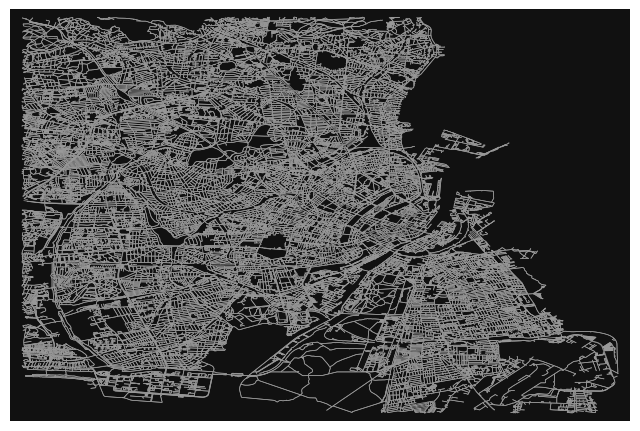

In [6]:
fig, ax = ox.plot_graph(g, node_size=0, edge_linewidth=0.5, show=False, close=False)
edges.plot(ax=ax, linewidth=1, edgecolor='black')

In [7]:
### carry weights over to line graph
H = nx.line_graph(g)
H.add_nodes_from((node, g.edges[node]) for node in H)

In [8]:
for s, t, v in H.edges:
    H.edges[(s, t, v)]['weight'] = g.edges[s]['length'] + g.edges[t]['length']

In [9]:
ebc = dict(nx.all_pairs_dijkstra_path(H, weight='weight', cutoff=1000))
def calc_bc(shortest_paths, graph):
    bc = {i : 0 for i in graph.nodes}
    for node in graph.nodes:
        for other_node in shortest_paths[node].keys():
            path = shortest_paths[node][other_node]
            for node_visited in path:
                bc[node_visited] += 1
    for node in bc.keys():
        bc[node] /= len(graph.nodes)
    return bc
bc = calc_bc(ebc, H)

In [10]:
bc = {k: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}

In [11]:
### color edges in g by bc
bc2 = {}
for x, y, z in bc:
    bc2[(x, y)] = bc[(x, y, z)]

for (s, t), value in bc2.items():
    for i in range(len(g[s][t])):
        g[s][t][i]['bc'] = value

In [12]:
### scale bc
cph = mp.nx_to_gdf(g)
cph_edges = cph[1].to_crs('EPSG:3857')
#cph_edges['bc'] = cph_edges['bc'] / cph_edges['bc'].max()
#cph_edges['bc'] = np.log10(cph_edges['bc'])

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_8539/4099654000.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  cph = mp.nx_to_gdf(g)


In [13]:
cph_edges

,osmid,highway,maxspeed,name,oneway,reversed,length,bc,lanes,geometry,ref,service,bridge,access,width,tunnel,junction,node_start,node_end
0,1355182986,tertiary,30,Banegårdspladsen,True,False,9.317127,0.003993,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61333
1,678991574,tertiary,50,Vesterbrogade,True,False,62.716378,0.001689,2,"LINESTRING (1398496.711 7493785.322, 1398520.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27662
2,2371125,primary,50,Vasbygade,True,False,74.252656,0.001771,2,"LINESTRING (1397998.578 7491414.067, 1397969.3...",O2,NaN,NaN,NaN,NaN,NaN,NaN,1,7
3,25996200,tertiary,40,Dybbølsbro,True,False,3.886737,0.031674,2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,48267
4,1240378687,primary_link,50,NaN,True,False,7.667997,0.015126,2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,11499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146237,1341798056,cycleway,NaN,NaN,True,False,17.148578,0.027372,NaN,"LINESTRING (1396446.473 7499967.229, 1396440.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,61390,61092
146238,47978082,tertiary,50,Tagensvej,False,False,30.074508,0.049992,4,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61391,4830
146239,47978082,tertiary,50,Tagensvej,False,True,16.743334,0.018565,4,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61391,18065
146240,1356542844,service,NaN,NaN,False,False,10.798745,0.006934,NaN,None,NaN,driveway,NaN,NaN,NaN,NaN,NaN,61391,61390


In [14]:
filepath = '/Users/manuel/Documents/Semester 4/Master_Thesis/Thesis_Repo/data/raw/trafiktaelling.json'

gdf = gpd.GeoDataFrame.from_file(filepath)
gdf.set_crs(epsg=4326, inplace=True)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

### export only relevant columns
gdf_new = gdf[['id', 'vejnavn', 'geometry', 'aadt_cykler']]
gdf_new = gdf_new[gdf_new['aadt_cykler'].notna()]

In [15]:
linestrings = [i[2]['geometry'] if 'geometry' in i[2] else None for i in list(g.edges(data=True))]
from_node = [i[0] for i in list(g.edges(data=True))]
to_node = [i[1] for i in list(g.edges(data=True))]
g = nx.Graph(g)

def find_nearest_edge(linestrings, point, from_node, to_node):
    # Initialize variables to find the closest edge
    shortest_distance = float('inf')
    closest_edge = None
    node_pair = None
    for linestring, n1, n2 in zip(linestrings, from_node, to_node):
        if linestring is not None:
            # Calculate the distance between the point and the edge
            distance = linestring.distance(point)
            if distance < shortest_distance:
                shortest_distance = distance
                closest_edge = linestring
                node_pair = (n1, n2)
    return closest_edge, shortest_distance, node_pair

In [16]:
g2 = g.copy()
import tqdm
for i, row in tqdm.tqdm(gdf_new.iterrows(), total=len(gdf_new)):
    point = row['geometry']
    closest_edge, shortest_distance, node_pair = find_nearest_edge(linestrings, point, from_node, to_node)
    try:
        g2[node_pair[0]][node_pair[1]]['aadt'] = row['aadt_cykler']
    except:
        print(node_pair)
        print(row['aadt_cykler'])
        print(i)

 83%|████████▎ | 556/671 [01:39<00:19,  5.81it/s]

None
9500.0
818


100%|██████████| 671/671 [02:00<00:00,  5.57it/s]


In [17]:
for edge in g2.edges(data=True):
    if 'aadt' not in edge[2]:
        g2[edge[0]][edge[1]]['aadt'] = 0

In [18]:
list(g2.edges(data=True))[3]

(118730,
 118751,
 {'osmid': 2371125,
  'highway': 'primary',
  'lanes': '2',
  'maxspeed': '50',
  'name': 'Vasbygade',
  'oneway': True,
  'ref': 'O2',
  'reversed': False,
  'length': np.float64(74.25265613124837),
  'geometry': <LINESTRING (12.558 55.662, 12.558 55.662, 12.558 55.662, 12.558 55.662, 12....>,
  'bc': 0.0017710370481804133,
  'aadt': 0})

In [19]:
cph_test = mp.nx_to_gdf(g2)

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_8539/464062924.py:1: UserWarning: Approach is not set. Defaulting to 'primal'.
  cph_test = mp.nx_to_gdf(g2)


In [20]:
cph_test = cph_test[1].to_crs('EPSG:3857')

In [21]:
cph_test

,osmid,highway,maxspeed,name,oneway,reversed,length,bc,aadt,lanes,geometry,ref,bridge,service,access,width,tunnel,junction,node_start,node_end
0,1355182986,tertiary,30,Banegårdspladsen,True,False,9.317127,0.003993,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61333
1,678991574,tertiary,50,Vesterbrogade,True,False,62.716378,0.001689,0.0,2,"LINESTRING (1398496.711 7493785.322, 1398520.1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27662
2,"[111683496, 678991574]","[tertiary_link, tertiary]",50,Vesterbrogade,True,False,24.976259,0.006647,0.0,2,"LINESTRING (1398466.777 7493754.724, 1398484.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,13454
3,2371125,primary,50,Vasbygade,True,False,74.252656,0.001771,0.0,2,"LINESTRING (1397998.578 7491414.067, 1397969.3...",O2,NaN,NaN,NaN,NaN,NaN,NaN,1,7
4,25996200,tertiary,40,Dybbølsbro,True,False,3.886737,0.031674,0.0,2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,48267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78203,1356542829,cycleway,NaN,NaN,True,False,15.334497,0.030791,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61385,61388
78204,1356542835,cycleway,NaN,NaN,True,False,10.421381,0.018387,0.0,NaN,"LINESTRING (1395941.773 7500544.069, 1395950.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,61385,61386
78205,1356542836,cycleway,NaN,NaN,True,False,10.309164,0.018415,0.0,NaN,"LINESTRING (1395939.546 7500579.436, 1395937.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,61387,61388
78206,1356542844,service,NaN,NaN,False,True,55.545046,0.005546,0.0,NaN,None,NaN,NaN,driveway,NaN,NaN,NaN,NaN,61389,61390


In [22]:
cph_cleaned = cph_test[cph_test['aadt'] > 0.0]

In [23]:
cph_cleaned

,osmid,highway,maxspeed,name,oneway,reversed,length,bc,aadt,lanes,geometry,ref,bridge,service,access,width,tunnel,junction,node_start,node_end
13,495915492,tertiary,40,Dybbølsbro,True,False,24.436424,0.006927,5700.0,2,"LINESTRING (1398354.11 7491621.898, 1398361.65...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,15701
65,494209714,tertiary,50,Center Boulevard,True,False,144.828304,0.010626,3500.0,3,"LINESTRING (1399899.804 7487013.196, 1399927.7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,2456
75,237099603,tertiary,50,Ørestads Boulevard,False,False,191.100626,0.003686,100.0,2,"LINESTRING (1400547.305 7486048.592, 1400543.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,7160
99,201965314,tertiary,50,Strandvejen,True,False,60.503868,0.077331,6400.0,2,"LINESTRING (1400104.031 7503205.251, 1400087.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,60738
194,431349799,residential,50,Gammel Jernbanevej,False,True,162.980131,0.006079,3000.0,2,"LINESTRING (1393295.04 7491891.331, 1393569.35...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,27003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77029,1233241067,path,NaN,NaN,False,True,42.217480,0.021328,400.0,NaN,"LINESTRING (1394830.359 7488488.153, 1394820.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,59657,59659
77159,1271151717,service,40,Kirsebærhaven,False,False,69.662442,0.002188,600.0,2,"LINESTRING (1391856.336 7488930.455, 1391854.4...",NaN,NaN,driveway,NaN,NaN,NaN,NaN,59881,59882
77336,1282826537,cycleway,NaN,NaN,False,True,20.703807,0.013259,7800.0,NaN,"LINESTRING (1397960.14 7492081.846, 1397940.00...",NaN,NaN,NaN,NaN,7,NaN,NaN,60155,60196
78033,42338009,tertiary,60,Oceanvej,False,True,68.827183,0.003966,400.0,2,"LINESTRING (1403537.302 7502162.043, 1403449.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,61119,61151


In [24]:
from sklearn.model_selection import train_test_split

x = cph_cleaned['bc']
x = x.to_numpy()
x = np.reshape(x, (-1,1))

y = cph_cleaned['aadt']
y = y.to_numpy()
y = np.reshape(y, (-1,1))


X_train, X_test, Y_train, Y_test= train_test_split(x,y, test_size=0.2)

In [25]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
predictions = reg.predict(X_test)
scores = reg.score(X_test, Y_test)

In [26]:
scores

0.0165376469052102

In [27]:
predictions

array([[4030.3047332 ],
       [4212.5568537 ],
       [4132.41952425],
       [4509.52060299],
       [3872.17421688],
       [4054.96237303],
       [3817.49858073],
       [4637.633123  ],
       [3969.19666927],
       [4023.87230542],
       [3935.69444123],
       [4543.8268845 ],
       [4432.33146961],
       [4197.0118199 ],
       [4981.49999153],
       [4140.99609462],
       [3952.31154634],
       [5472.5086456 ],
       [4570.89668475],
       [3914.52103312],
       [5278.195723  ],
       [3976.1651327 ],
       [4140.99609462],
       [4314.93966257],
       [4041.02544617],
       [3840.28009579],
       [4056.03444433],
       [3955.52776023],
       [3986.61782784],
       [3983.40161395],
       [4037.80923228],
       [5905.89346744],
       [4068.8992999 ],
       [4050.94210567],
       [4031.10878667],
       [4683.73218877],
       [3957.67190282],
       [4220.32937061],
       [4610.83134057],
       [3871.37016341],
       [3950.70343939],
       [3951.239

In [28]:
import scipy.stats as stats
stats.spearmanr(x,y)

SignificanceResult(statistic=np.float64(0.21593797625396624), pvalue=np.float64(3.61432458131844e-08))

<Axes: >

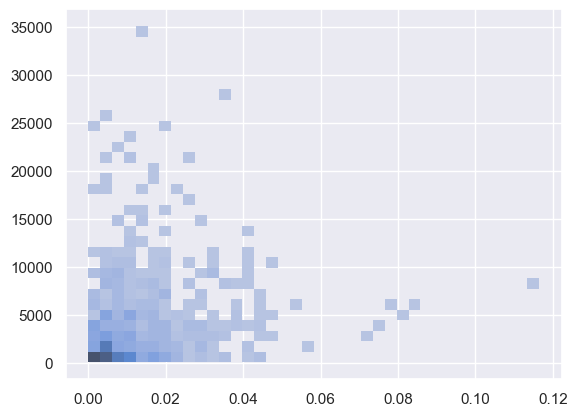

In [29]:
sns.histplot(x=x[:,0], y = y[:,0])